In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
#from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list, Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif, cross, dot

from desc.optimize import lsqtr, lsq_auglag

from desc.magnetic_fields import FourierCurrentPotentialField

import time

import numpy as np
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                            plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

#from find_sour import iso_coords_interp, bn_res, B_sour, K_sour, interp_grid, add_extra_coords, add_extra_periodic
from desc.objectives.find_sour import iso_coords_load, iso_coords_interp

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

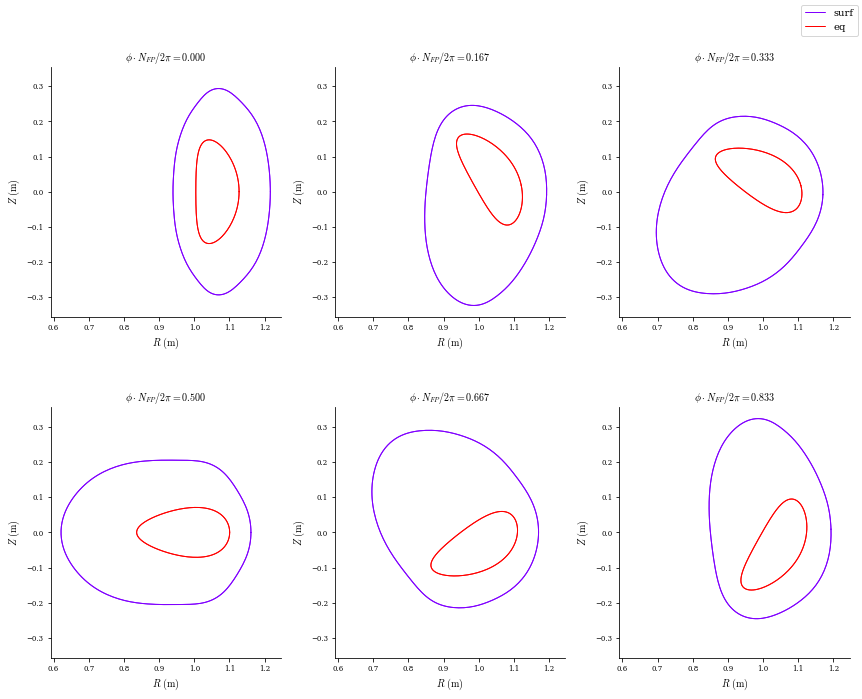

In [3]:
# Plasma surfaces
#eqname_QA = "/scratch/gpfs/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eqname_QA = "input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eq = eq_QA

name = './iso_coords/'
# Winding surfac./e
surf_winding = load(name + "surf.h5")

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

In [4]:
tdata = iso_coords_load(name,surf_winding)

In [5]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 100, N = 150,
                   NFP = surf_winding.NFP,
                  )
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid)
sdata = iso_coords_interp(tdata, sdata, sgrid,)

G = np.load(name + "G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

In [6]:
sgrid2 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*1)).T
                    )
sgrid3 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*2)).T
                    )

sdata2 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid2)
sdata2 = iso_coords_interp(tdata, sdata2, sgrid2)

sdata3 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid3)
sdata3 = iso_coords_interp(tdata, sdata3, sgrid3)

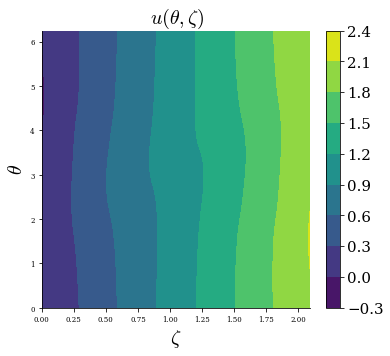

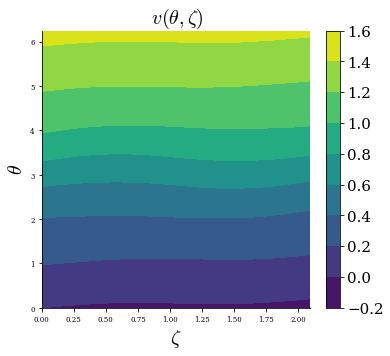

In [7]:
# Confirm that variables have the same shape
plot_figure2(sdata["u_iso"],sgrid,''r' $ u(\theta,\zeta)$ ')
plot_figure2(sdata["v_iso"],sgrid,''r' $ v(\theta,\zeta)$ ')
#plot_figure2(sdata["lambda_iso"],sgrid,''r' $ \lambda $ ')

#plot_figure2(sdata2["u_iso"],sgrid2,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata2["v_iso"],sgrid2,''r' $ v(\theta,\zeta)$ ')

#plot_figure2(sdata3["u_iso"],sgrid3,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata3["v_iso"],sgrid3,''r' $ v(\theta,\zeta)$ ')

In [8]:
eps = 1e-2
dt = eps
dz = eps
d0 = eps/3

In [9]:
grid_M = 50
grid_N = 50

In [10]:
egrid = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

#B_s = edata["B"]
B_sec = np.load('iso_coords/B_sec_'+str(grid_M)+'x'+str(grid_N)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
B_s = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid, basis = "rpz" )
#B_s = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2],
                      jnp.asarray([0])))
#- dot( edata["n_rho"],  B_sec )

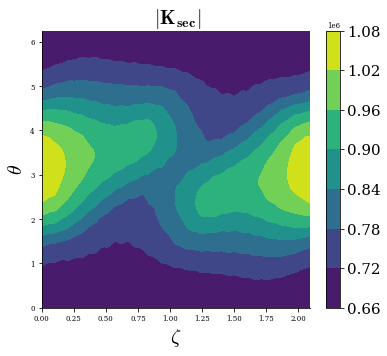

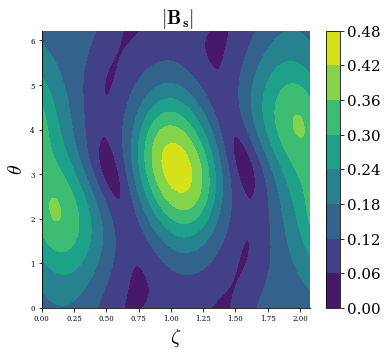

In [11]:
plot_figure2( dot(K_sec,K_sec) ** (1/2), sgrid,''r' $ | \mathbf{K_{sec}} |$ ')
plot_figure2( dot(B_s,B_s) ** (1/2), egrid,''r' $ | \mathbf{B_{s}} |$ ')
#plot_figure2( rhs, egrid, ''r' $ \mathbf{B_{sec} \cdot n}$ ' )

In [12]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
sMv = np.asarray([60,]) # Poloidal direction
sNv = np.asarray([60,]) # Toroidal direction

In [13]:
p_M = sMv[0]
p_N = sNv[0]

#theta = jnp.linspace(2 * jnp.pi * (1 / (p_M * 2)) * 1/2,
#                         2 * jnp.pi * (1 - 1 / (p_M * 2) * 1/2),
#                         p_M * 2)

#zeta = jnp.linspace(2 * jnp.pi / surf_winding.NFP * (1 / (p_N * 2)) * 1/2,
#                        2 * jnp.pi / surf_winding.NFP * (1 - 1 / (p_N * 2) * 1/2),
#                        p_N * 2,)

#name = "iso_coords/"
#s_data = interp_grid(theta, zeta, surf_winding, name)

## Save the dictionary
#with open('s_data.pkl', 'wb') as f:
#    pickle.dump(s_data, f)

In [14]:
grid_M2 = grid_M
grid_N2 = grid_N

egrid2 = LinearGrid(M = grid_M2, N = grid_N2, NFP = eq.NFP)
edata2 = eq.compute(["n_rho"], grid = egrid2)

B_sec2 = np.load('iso_coords/B_sec_'+str(grid_M2)+'x'+str(grid_N2)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid2, basis = "rpz" )
B_s2 = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid2, basis = "rpz" )
#B_s2 = edata2["B"]

In [15]:
b_chi = [] # Store the integral of the error 
source_chi = [] # Store the sum of sinks and sources of current
Bn_chi = [] # Store the max Bn from the solution
max_I = [] # Store the max value of sources
min_I = [] # Store the min value of sources

In [16]:
from desc.magnetic_fields._sinkssources import SinksSources

from desc.objectives import (
    ObjectiveFunction,
    SinksSourcesSurfaceQuadraticFlux,
    SinksSourcesSum,
    SinksSourcesRegularization,
)

In [17]:
sinks_sources_basis = SinksSources(p_M=p_M,p_N=p_N, NFP = surf_winding.NFP)

In [18]:
obj_bn = SinksSourcesSurfaceQuadraticFlux(
            sinks_sources_basis, # Field for sinks and sources,
            eq,
        surf_winding, # Winding surface
        tdata, # Dictionary with information about the isothermal coordinates
        N, # Nnumber of terms for the sum in the Jacobi-theta function
        d0, # Regularization radius for Guenther's function
        #normalize=True,
        #normalize_target=True,
        source_grid=sgrid, #Grid with the locations of the sources and sinks
        eval_grid=egrid,
        field_grid=sgrid,
        #sin_and_source_grid=None,
        vacuum=False,
        name="Sinks/Sources Quadratic flux",
        jac_chunk_size=None,)

In [19]:
obj_reg = SinksSourcesRegularization(
    sinks_sources_basis, # Field for sinks and sources,
    eq,
    eval_grid=egrid,
    field_grid=sgrid,
    weight=1e-14,
    vacuum=False,
    name="Sinks/Sources Regularization",
    jac_chunk_size=None,
    )

In [20]:
objective = ObjectiveFunction(
    (
        obj_bn,
        obj_reg,
    )
)

In [21]:
constraints = (SinksSourcesSum(sinks_sources_basis, # Field for sinks and sources,
            eq,
        eval_grid=egrid,
        field_grid=sgrid,
        vacuum=False,
        name="Sinks/Sources Quadratic flux",
        jac_chunk_size=None,
                              ),
               )

In [22]:
from desc.optimize import Optimizer

optimizer = Optimizer("lsq-auglag")

In [23]:
#(eq, field), _
result = optimizer.optimize(
    #(surf_winding,sinks_sources_basis),
    sinks_sources_basis,
    objective, 
    constraints = constraints, 
    maxiter=1, 
    verbose=3
)

Building objective: Sinks/Sources Quadratic flux

Precomputing transforms

Timer: Precomputing transforms = 3.99 sec

Building objective: Sinks/Sources Regularization

Precomputing transforms

Timer: Precomputing transforms = 29.7 ms

Timer: Objective build = 9.04 sec

Building objective: Sinks/Sources Quadratic flux

Precomputing transforms

Timer: Precomputing transforms = 28.7 ms

Timer: Objective build = 33.9 ms

Number of parameters: 1

Number of objectives: 20402

Number of equality constraints: 10201

Number of inequality constraints: 0

Timer: Initializing the optimization = 9.24 sec


Starting optimization

Using method: lsq-auglag

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality    Constr viol.   Penalty param  max(|mltplr|) 

       0              1          5.110e+09                                    1.654e+07      5.180e+04      1.000e+01      0.000e+00   

       1              2          5.110e+09      6.177e+02      8.850e-04      1.654e+07      5.180e+04      1.000e+01      0.000e+00   

         Current function value: 5.110e+09

         Constraint violation: 5.180e+04

         Total delta_x: 8.850e-04

         Iterations: 1

         Function evaluations: 2

         Jacobian evaluations: 1

Timer: Solution time = 2.14 min

Timer: Avg time per step = 1.07 min

                                                                 Start  -->   End
Total (sum of squares):                                      5.110e+09  -->   5.110e+09, 
Maximum absolute Boundary normal field error:                7.509e+02  -->   7.509e+02 (T m^2)
Minimum absolute Boundary normal field error:                9.068e+01  -->   9.068e+01 (T m^2)
Average absolute Boundary normal field error:                2.682e+02  -->   2.682e+02 (T m^2)
Maximum absolute Boundary normal field error:                6.797e+03  -->   6.797e+03 (normalized)
Minimum absolute Boundary normal field error:                8.207e+02  -->   8.207e+02 (normalized)
Average absolute Boundary normal field error:                2.427e+03  -->   2.427e+03 (normalized)
Maximum absolute Boundary normal field error:                2.144e+08  -->   2.144e+08 (T m^2)
Minimum absolute Boundary normal field error:                2.144e+08  -->   2.144e+08 (T m^2)
Average absolute Boundary normal field error: